# Exporting to Google Drive from the Sandbox

## Background
<a class="anchor" id="background"></a>

The Google Drive API enables developers to integrate Google Drive functionality into applications, offering access to file storage, sharing, and synchronization capabilities.
It allows users to manage files, folders, and permissions programmatically, facilitating seamless integration of cloud storage features into various software solutions.
The API supports multiple programming languages and provides robust documentation, making it versatile for a wide range of applications from document management to collaborative platforms. More information can be found [here](https://developers.google.com/workspace/drive/api/guides/about-sdk).

[PyDrive2](https://docs.iterative.ai/PyDrive2/) is a wrapper library of [google-api-python-client](https://github.com/googleapis/google-api-python-client/blob/main/docs/README.md) that simplifies many common Google Drive API V2 tasks.
The `deafrica_tools.externaldrive.authenticate` function uses functionality from the `PyDrive2` library to authenticate and authorize API requests, enabling seamless integration of Google Drive functionalities directly into data science workflows without user intervention.

To connect to the Google Drive API from the sandbox, follow the instructions [here](https://developers.google.com/workspace/drive/api/quickstart/python) to:
1. Enable the Google Drive API
2. Configure the OAuth consent screen
3. Authorize credentials for a desktop application

At the end of the instructions in step 3, Authorize credentials for a desktop application, you will be asked to save a downloaded JSON file as `credentials.json`. 
Once you have completed this step, upload the `credentials.json` file into the folder `/home/jovyan/Supplementary_data/DriveCredentials`.

If you wish to use a different folder to store your credentials JSON file and user access token JSON file, once you have uploaded the `credentials.json` into the desired folder, pass the absolute path of the folder to the variable `gdrive_credentials_dir`.

<div style="background-color:#f8d7da; color:#721c24; padding:10px; border-radius:5px; border:1px solid #f5c6cb;">
    ⚠️ <strong>Security considerations:</strong> Users should take care to ensure the security of credentials uploaded into the Sandbox. This includes ensuring they are not incidentally included in uploads to public repositories like GitHub.
</div>

## Description

This notebook provides a brief introduction to accessing and using Digital Earth Africa's sandbox with Google Drive:

* [1 - Authorize and authenticate Google Drive credentials](#authorize-and-authenticate)
* [2 - Interacting with Google Drive using the fsspec filesystem](#interacting-with-gdrive)
  * [Creating a directory](#creating-a-directory)
  * [Upload files](#upload-files)
  * [Read files](#read-files)
  * [Delete files](#delete-files)
  * [Writing files](#writing-files)
  * [Download files](#download-files)

## Getting started
<a class="anchor" id="getting-started"></a>

## Load packages

Import Python packages that are used for the analysis.

In [1]:
import os

import datacube
import matplotlib.pyplot as plt
import odc.algo
import rasterio
import rioxarray
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.externaldrive import authenticate
from deafrica_tools.plotting import rgb
from odc.geo.xr import write_cog
from pydrive2.fs import GDriveFileSystem

## Authorize and authenticate Google Drive credentials 
<a class="anchor" id="authorize-and-authenticate"></a>

In this section, we will use the `authenticate` function to handle the authorization and authentication process for Google Drive using PyDrive2. 
The function ensures the Google Drive API credentials (`credentials.json`) are correctly loaded, manages the access token (`token.json`), and returns a `GoogleAuth` object that we will user to interact with Google Drive (upload, download, or manage files).

Set the folder that the `credentials.json` file is located in.

In [2]:
gdrive_credentials_dir = "/home/jovyan/Supplementary_data/DriveCredentials"

If running the cell below for the first time, a url will be printed in the cell output and you will be prompted to enter a authorization/verification code. 
To obtain this code perform the following steps:
1. Copy the url link and open it in your browser. 
2. You will be requested to choose an account.
   Click on the Google Account that you downloaded the `credentials.json` JSON file for.
4. In the next 2 screens click **Continue** until you come to a page with an Authorization code section.
5. Copy the code and input it into the input box and press Enter.

![authentication.png](../Supplementary_data/DriveCredentials/authentication_firsttime.png)

Once you have completed step 5, the cell will run and you will see the message `Authentication successful.` printed in the cell output.

If you have already run the code cell below before **and** a user access token (`token.json`) was generated, you will see the following messages printed in the cell output. 

![authentication](../Supplementary_data/DriveCredentials/authentication_notfirsttime.png)

In [3]:
gauth =  authenticate(gdrive_credentials_dir)

✅ Found existing settings file: /home/jovyan/Supplementary_data/DriveCredentials/settings.yaml
✅ Found credentials: /home/jovyan/Supplementary_data/DriveCredentials/credentials.json
✅ Found existing access token: /home/jovyan/Supplementary_data/DriveCredentials/token.json


## Interacting with Google Drive using the fsspec filesystem
<a class="anchor" id="interacting-with-gdrive"></a>

PyDrive2 provides an easy way to work with your files through the [`fsspec`](https://filesystem-spec.readthedocs.io/en/latest/) compatible [`GDriveFileSystem`](https://docs.iterative.ai/PyDrive2/pydrive2/#pydrive2.fs.GDriveFileSystem).
A `fsspec` filesystem instance offers a large number of methods for getting information about and manipulating files, refer to the fsspec docs on [how to use a filesystem](https://filesystem-spec.readthedocs.io/en/latest/usage.html#use-a-file-system).

This section of the notebook will walk you through how to upload, download or manage files using `fsspec` functionality.

### Creating a directory
<a class="anchor" id="creating-a-directory"></a>

In this section, we will create a folder in your Google Drive to store outputs from this notebook.
All folder and file paths should be absolute and start from the `root` directory. Paths not starting with `root` may be considered invalid.
`root` refers to the top-level directory in Google Drive, known as "My Drive", which serves as the primary heirachy for all user files and folders. 
This root folder is the starting point for organizing content within Google Drive, and all other folders and files descend from it.

Instantiate a fsspec compatible filesystem instance using `GDriveFileSystem` and the `GoogleAuth` object we created in the [Authorize and authenticate Google Drive credentials](#authorize-and-authenticate) section.

In [4]:
# "root" is the root folder of your Google Drive
fs = GDriveFileSystem("root", google_auth = gauth)

Create a folder in your Google Drive.

<div style="background-color:#d1ecf1; color:#0c5460; padding:10px; border-radius:5px; border:1px solid #bee5eb;">
    ℹ️ <strong>Info:</strong> All folder and file paths should be absolute and start from the `root` directory.
    Paths not starting with `root` may be considered invalid.
</div>

In [5]:
folder_path = "root/basic_analysis"

In [6]:
fs.mkdir(folder_path)

### Upload files 
<a class="anchor" id="upload-files"></a>

In this section we will upload a file on the sandbox into the folder created in the previous section.

Define the absolute path of the file on Google Drive.

In [7]:
file_path = "root/basic_analysis/test_gdrive.txt"

Create the text file to be uploaded by writing items in a list to a text file. 

In [8]:
data_list = [
    "First item to write.",
    "Second item to write.",
    "Third item to write."
]
with open("test_local.txt", 'w') as f:
    for item in data_list:
        f.write(item + '\n')

Upload the file to Google Drive.

In [9]:
fs.upload("test_local.txt", file_path)

Verify the file was uploaded by listing items in the folder. 

In [10]:
fs.ls("root")

['root/basic_analysis/']

In [11]:
fs.ls("root/basic_analysis/")

['root/basic_analysis/test_gdrive.txt']

### Read files
<a class="anchor" id="read-files"></a>

In this section we will read the text file we uploaded to Google Drive in the previous section.

In [12]:
file_path = "root/basic_analysis/test_gdrive.txt"

In [13]:
# Read files from drive
with fs.open(file_path, "r") as f:
    lines = f.readlines()

# Remove newline characters
lines = [line.strip() for line in lines]

print(lines)

['First item to write.', 'Second item to write.', 'Third item to write.']


### Delete files
<a class="anchor" id="delete-files"></a>

In this section we will delete the text file we uploaded to Google Drive in the previous section.

In [14]:
file_path = "root/basic_analysis/test_gdrive.txt"

In [15]:
fs.rm(file_path)

Verify the file was deleted by listing items in the folder. 

In [16]:
fs.ls("root/basic_analysis/")

[]

### Writing files
<a class="anchor" id="writing-files"></a>

In this section we will write a file directly to Google Drive.
This can be a more efficient way to get files onto your Google Drive than having to write them locally first then uploading to Google Drive as seperate steps.

This section will revisit parts of the workflow demonstrated in the [Performing a basic analysis notebook](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Beginners_guide/05_Basic_analysis.ipynb) notebook.

Define the analysis parameters.

In [17]:
# Connect to the datacube
dc = datacube.Datacube(app="Basic_analysis")

# Select a study area and a buffer
# Set the central latitude and longitude
central_lat = -31.5393
central_lon = 18.2682

# Set the buffer to load around the central coordinates
buffer = 0.03

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

Load the Sentinel-2 data for the area of interest.

In [18]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "s2_l2a"

# Set the date range to load data over
set_time = ("2018-01-01", "2018-01-15")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
    "red",
    "blue",
    "green",
    "nir"
]

# Set the coordinate reference system and output resolution
set_crs = 'EPSG:6933'
set_resolution = (-10, 10)

In [19]:
dataset = dc.load(
    product=set_product,
    x=study_area_lon,
    y=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    output_crs=set_crs,
    resolution=set_resolution,
    group_by='solar_day'
)
dataset

<xarray.Dataset> Size: 9MB
Dimensions:      (time: 3, y: 655, x: 580)
Coordinates:
  * time         (time) datetime64[ns] 24B 2018-01-04T08:57:02 ... 2018-01-14...
  * y            (y) float64 5kB -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 5kB 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (time, y, x) uint16 2MB 2502 2600 2754 2754 ... 1826 953 1238
    blue         (time, y, x) uint16 2MB 955 949 1015 1011 ... 1094 918 552 780
    green        (time, y, x) uint16 2MB 1580 1630 1718 1700 ... 1310 827 1005
    nir          (time, y, x) uint16 2MB 3200 3366 3442 3504 ... 2946 2420 1908
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Select the timestep to use in the workflow.

In [20]:
dataset = dataset.isel(time=0)
dataset

<xarray.Dataset> Size: 3MB
Dimensions:      (y: 655, x: 580)
Coordinates:
    time         datetime64[ns] 8B 2018-01-04T08:57:02
  * y            (y) float64 5kB -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 5kB 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (y, x) uint16 760kB 2502 2600 2754 2754 ... 1788 1462 993 1208
    blue         (y, x) uint16 760kB 955 949 1015 1011 954 ... 1007 771 495 820
    green        (y, x) uint16 760kB 1580 1630 1718 1700 ... 1380 1094 805 1001
    nir          (y, x) uint16 760kB 3200 3366 3442 3504 ... 2692 2976 2542 2024
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Use the `rgb()` function to plot the selected time step. 
The `rgb()` function maps three data variables/measurements from the loaded dataset to the red, green and blue channels that are used to make a three-colour image.

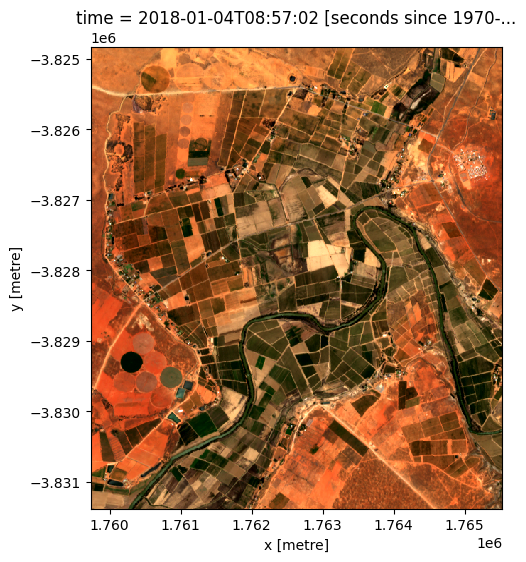

In [21]:
rgb(dataset)

Calculate vegetation health from the selected data.

In [22]:
# Convert dataset to float32 datatype so no-data values are set to NaN
dataset =  odc.algo.to_f32(dataset)
# Calcule NDVI
ndvi = calculate_indices(dataset, index="NDVI", satellite_mission="s2", drop=True)
ndvi

Dropping bands ['red', 'blue', 'green', 'nir']


<xarray.Dataset> Size: 2MB
Dimensions:      (y: 655, x: 580)
Coordinates:
    time         datetime64[ns] 8B 2018-01-04T08:57:02
  * y            (y) float64 5kB -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 5kB 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 4B 6933
Data variables:
    NDVI         (y, x) float32 2MB 0.1224 0.1284 0.111 ... 0.3411 0.4382 0.2525
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

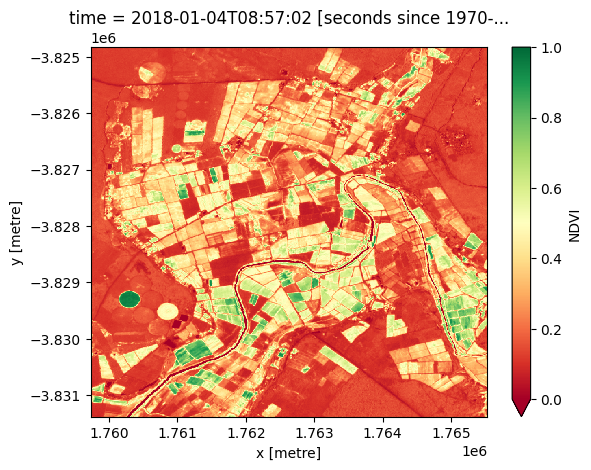

In [23]:
# Plot the NDVI band
ndvi["NDVI"].plot(cmap="RdYlGn", vmin=0, vmax=1)
plt.show()

Export the `NDVI` band to a COG file in your Google drive using the `write_cog()` command from the `odc-geo` library and `fsspec`.

In [24]:
cog_file_path = "root/basic_analysis/ndvi.geotiff"

First write the `xarray.DataArray` into an in memory COG file.

In [25]:
da = ndvi.NDVI
da

<xarray.DataArray 'NDVI' (y: 655, x: 580)> Size: 2MB
array([[0.12241318, 0.12839426, 0.11103933, ..., 0.12687685, 0.1313949 ,
        0.12835819],
       [0.12829289, 0.1247136 , 0.10674693, ..., 0.12770721, 0.13333334,
        0.13129775],
       [0.12309822, 0.12321488, 0.11476469, ..., 0.13343924, 0.13364053,
        0.13167256],
       ...,
       [0.09936731, 0.1018315 , 0.09043151, ..., 0.35731646, 0.369863  ,
        0.13691507],
       [0.15498447, 0.14464428, 0.12185836, ..., 0.3640167 , 0.4338498 ,
        0.19569121],
       [0.17833877, 0.16302522, 0.14487337, ..., 0.34114465, 0.43818957,
        0.25247523]], dtype=float32)
Coordinates:
    time         datetime64[ns] 8B 2018-01-04T08:57:02
  * y            (y) float64 5kB -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
  * x            (x) float64 5kB 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
    spatial_ref  int32 4B 6933

In [26]:
cog_bytes = write_cog(
                    geo_im=ndvi.NDVI,
                    fname=":mem:",
                    overwrite=True,
                )

Write the in-memory file to your Google Drive using `fsspec`.

In [27]:
with fs.open(cog_file_path, "wb") as f:
    f.write(cog_bytes)

Verify the file was uploaded by listing items in the folder. 

In [28]:
fs.ls("root/basic_analysis/")

['root/basic_analysis/ndvi.geotiff']

You can read the GeoTIFF file you've uploaded into an `xarray.DataArray` directly, keeping in mind the constraints highlighted below.

<div style="background-color:#fff3cd; color:#856404; padding:10px; border-radius:5px; border:1px solid #ffeeba;">
    ⚠️ <strong>Warning:</strong> The file object returned by fsspec for Google Drive is streaming-only. 
It does not supports random access which is required by `rasterio` in order to read headers, bands, and offsets in a COG.
The method demonstrated below will read all bytes into memory. 
For very large files, this may crash or slow your system.
</div>



In [29]:
# read all bytes from GDrive
data = fs.open(cog_file_path, "rb").read() 
with rasterio.io.MemoryFile(data) as memfile:
    ndvi_from_gdrive = rioxarray.open_rasterio(memfile)

ndvi_from_gdrive

<xarray.DataArray (band: 1, y: 655, x: 580)> Size: 2MB
[379900 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
  * y            (y) float64 5kB -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

### Download files
<a class="anchor" id="download-files"></a>

An alternative to reading files directly from Drive is to download the file first then read the downloaded file.
This can be especially useful for larger than memory files. 

Specify the path to download the file to.. 
This can be relative to this notebook or an absolute file path.

In [30]:
download_path = "ndvi_downloaded.tiff"

Specify the path of the file to download from Google Drive.

In [31]:
gdrive_file_path = "root/basic_analysis/ndvi.geotiff"

Use ``fsspec`` to download the file.

In [32]:
fs.get(gdrive_file_path, download_path)

Verify if the file was downloaded.

In [33]:
if os.path.exists(download_path):
    print("File was successfully downloaded")

File was successfully downloaded


In [34]:
# Read the downloaded geotiff file.
ndvi_ = rioxarray.open_rasterio(download_path)
ndvi_

<xarray.DataArray (band: 1, y: 655, x: 580)> Size: 2MB
[379900 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB 1.76e+06 1.76e+06 ... 1.766e+06 1.766e+06
  * y            (y) float64 5kB -3.825e+06 -3.825e+06 ... -3.831e+06 -3.831e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Digital Earth Africa Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [35]:
import datacube
print(datacube.__version__)

1.8.20


**Last Tested:**

In [36]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-11-04'